In [ ]:
!pip install -q pymorphy2 snorkel dostoevsky transformers pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 59.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00


In [ ]:
import re
import pyspark.pandas as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy2
import torch
import nltk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from dostoevsky.models import FastTextSocialNetworkModel
from dostoevsky.tokenization import RegexTokenizer
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from snorkel.labeling.apply.spark import SparkLFApplier
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

!wget -O 'fasttext-social-network-model.bin' -q https://www.dropbox.com/s/p3ulnyhvqworjau/fasttext-social-network-model.bin?dl=0
!wget -O 'comments.parquet' -q https://www.dropbox.com/s/98wzn9tmusa8egh/comments.parquet?dl=0
!wget -O 'ground_truth.csv' -q https://www.dropbox.com/s/ra1ecymz5ggfom1/ground_truth.csv?dl=0

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


---

### Обработка датасета

In [ ]:
APP_NAME = 'catastriphizing_detection'

In [ ]:
spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    .getOrCreate()
)

In [ ]:
data = spark.read.option('header', True).parquet('comments.parquet')

In [ ]:
data.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- author_display_name: string (nullable = true)
 |-- comment_like_count: long (nullable = true)
 |-- comment_updated_at: string (nullable = true)



In [ ]:
data.count()

1499988

In [ ]:
data.show()

+-----------+--------------------+--------------------+-------------------+------------------+--------------------+
|   video_id|          comment_id|        comment_text|author_display_name|comment_like_count|  comment_updated_at|
+-----------+--------------------+--------------------+-------------------+------------------+--------------------+
|qqYVHnmvyi4|Ugx5Q3hB7qm02RFpP...|Просто представьт...|          Анастасия|                 1|2021-04-29T17:12:55Z|
|SajTzXP-dyM|Ugx3gxuZle6yZHaXd...|Да ясно, какое ре...| Larisa Uanchevskaa|                29|2021-04-29T17:12:39Z|
|ftSiZBr4nkM|UgwhnM9rIGB-Tf2sA...|Будьте прокляты в...|          xtAqHNpFg|                 0|2021-04-29T17:12:34Z|
|ftSiZBr4nkM|UgzvMrrSppANncEG6...|Народ просыпается...|          His Phone|                 1|2021-04-29T17:12:31Z|
|ftSiZBr4nkM|UgwrWbNXxuzalfb-0...|Вы настоящие патр...|          His Phone|                 1|2021-04-29T17:12:20Z|
|0EBJhFip9v4|UgyrxXgfQnm2X5hMB...|Снова уходишь? По...|       Boris Брит

In [ ]:
comments_text = data[['comment_id', 'comment_text']].limit(150000)

In [ ]:
lemmatizer = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("russian")
stop_words = [sw for sw in stop_words if sw not in ['не', 'ничего', 'совсем',
                                                    'никогда', 'хорошо', 'вдруг',
                                                    'если', 'может', 'лучше',
                                                    'я', 'мне', 'меня', 'нет']]
stop_words.extend(['это', 'всё', 'ещё'])

In [ ]:
def preprocess(text):
    text = re.sub('<.*?>|https?://\S+|@\w+|[^\w\s]|\d+|[^\u0400-\u04FF\s]', '', text.lower())
    text = re.sub(r'|\b\w*(\w)\1+\w*\b', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = list(filter(str.isalpha, word_tokenize(text)))
    text = list(word.replace('ё', 'е') for word in text if word not in stop_words)
    return ' '.join(text)

In [ ]:
def normalize(text):
    text = [lemmatizer.parse(word)[0].normal_form for word in text.split(' ') if word.isalpha()]
    return ' '.join(text)

In [ ]:
preprocess_udf = F.udf(preprocess, T.StringType())
normalize_udf = F.udf(normalize, T.StringType())

In [ ]:
comments_text = comments_text.withColumn('tokens', preprocess_udf(F.col('comment_text')))
comments_text = comments_text.withColumn('comment_len', F.length('tokens'))
comments_text = comments_text.withColumn('normalized_tokens', normalize_udf(F.col('tokens')))
comments_text = comments_text.filter(comments_text.comment_len > 0)
comments_text = comments_text.dropDuplicates(['tokens'])

In [ ]:
comments_text = comments_text.to_pandas_on_spark()

In [ ]:
# гистограмма распределения кол-ва символов
comments_text['comment_len'].plot.hist(bins=50)

---

### Обработка ground_truth датасета

Вручную было отобрано чуть более 100 представителей класса с катастрофизацией

In [ ]:
gt = pd.read_csv('ground_truth.csv')[['comment_id', 'comment_text']]

In [ ]:
gt.loc[:, 'tokens'] = gt.apply(lambda row: preprocess(row['comment_text']), axis=1)
gt.loc[:, 'normalized_tokens'] = gt.apply(lambda row: normalize(row['tokens']), axis=1)

In [ ]:
def draw_wordcloud(texts, max_words=1000, width=500, height=250):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

In [ ]:
fdist_uni_catast = FreqDist(' '.join(gt['tokens'].to_list()).split())
fdist_uni_catast.most_common(10)

[('не', 88),
 ('людей', 19),
 ('я', 18),
 ('если', 17),
 ('конец', 16),
 ('будут', 14),
 ('люди', 13),
 ('ужас', 12),
 ('нет', 11),
 ('света', 10)]

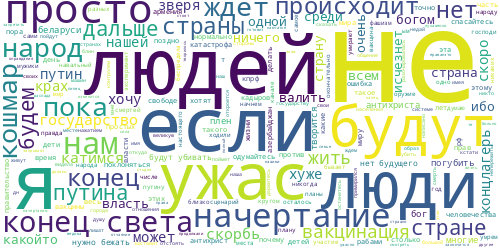

In [ ]:
draw_wordcloud(gt['tokens'].to_list())

In [ ]:
bigrams_catast = []

bigrams_catast.extend([bigram for comment in gt['tokens']
                       for bigram in list(nltk.bigrams(comment.split()))])

In [ ]:
fdist_bi_catast = FreqDist(bigrams_catast)
fdist_bi_catast.most_common(10)

[(('конец', 'света'), 9),
 (('нет', 'будущего'), 4),
 (('нужно', 'бежать'), 4),
 (('нам', 'конец'), 4),
 (('я', 'не'), 4),
 (('будут', 'убивать'), 4),
 (('не', 'хочу'), 3),
 (('если', 'не'), 3),
 (('простых', 'людей'), 3),
 (('часть', 'людей'), 3)]

In [ ]:
catast_gt_len = [len(comment) for comment in gt['tokens']]

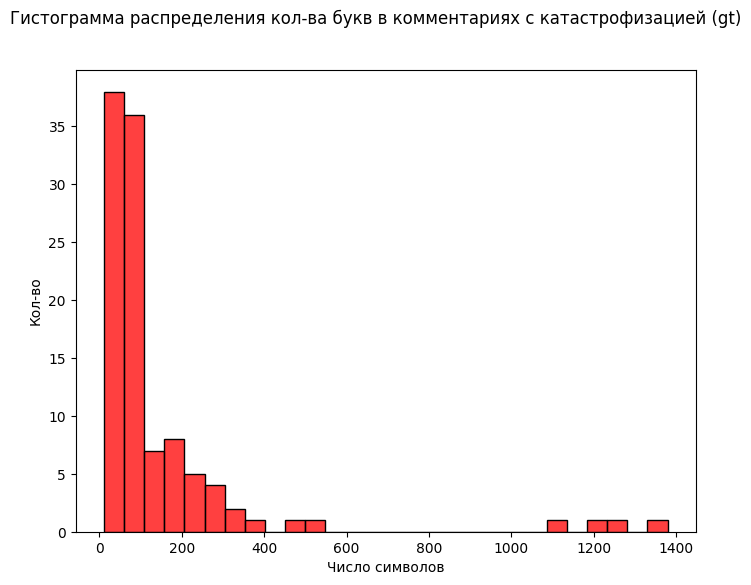

In [ ]:
fig = plt.figure(figsize=(8,6))

sns.histplot(catast_gt_len, color='red')
plt.ylabel('Кол-во')
plt.xlabel('Число символов')

fig.suptitle('Гистограмма распределения кол-ва букв в комментариях с катастрофизацией (gt)')
plt.show()

In [ ]:
def get_postags(tokens):
    return ' '.join([lemmatizer.tag(token)[0].POS for token in tokens.split()
                     if lemmatizer.tag(token)[0].POS != None])

In [ ]:
def count_pos(df):
    df['token_count'] = df.tokens.apply(lambda x: len(x.split()))
    df['pos'] = df.tokens.apply(lambda x: get_postags(x))
    df['noun_count'] = df.pos.apply(lambda x: x.count('NOUN')) / df['token_count']
    df['adj_count'] = df.pos.apply(lambda x: len(re.findall(r'ADJF|ADJS', x))) / df['token_count']
    df['infn_count'] = df.pos.apply(lambda x: x.count('INFN')) / df['token_count']
    df['advb_count'] = df.pos.apply(lambda x: x.count('ADVB')) / df['token_count']

    return df

In [ ]:
gt = count_pos(gt)

In [ ]:
gt.head()

,comment_id,comment_text,tokens,normalized_tokens,token_count,pos,noun_count,adj_count,infn_count,advb_count
1529471,UgxKqpGNW6gq860Cp8Z4AaABAg,Что происходит? Люди мозгами сдвинулись на фон...,происходит люди мозгами сдвинулись фоне войнаэ...,происходить человек мозг сдвинуться фон войнаэ...,9,VERB NOUN NOUN VERB NOUN ADJS ADJS NOUN ADJS,0.444444,0.333333,0.000000,0.0
1557894,UgykGN9a68XXzRAJbRZ4AaABAg,Господи Кремль останови эту Чечню!!!! Надо вал...,господи кремль останови чечню валить я детей л...,господь кремль остановить чечня валить я ребён...,18,NOUN NOUN VERB NOUN INFN NPRO NOUN PRCL INFN P...,0.444444,0.111111,0.111111,0.0
1594038,UgxpDXQattYCMINl8Jt4AaABAg,Чет пожалуй нахер мне гражданство такой позорн...,чет пожалуй нахер мне гражданство позорной стр...,чета пожалуй нахер я гражданство позорный стра...,9,NOUN CONJ NOUN NPRO NOUN ADJF NOUN INFN NOUN,0.555556,0.111111,0.111111,0.0
1618558,UgyQ1fwqbmaVqSUgRP14AaABAg,Конец света близко слишком близко.,конец света близко слишком близко,конец свет близко слишком близко,5,NOUN NOUN ADVB ADVB ADVB,0.400000,0.000000,0.000000,0.6
1624222,UgzLX0TlMXaJyaumSVd4AaABAg,Почему Путин не может остановит Кадырова. Вы с...,почему путин не может остановит кадырова сами ...,почему путин не мочь остановить кадыров сам не...,30,ADVB NOUN PRCL VERB VERB NOUN ADJF PRCL VERB A...,0.433333,0.066667,0.000000,0.1


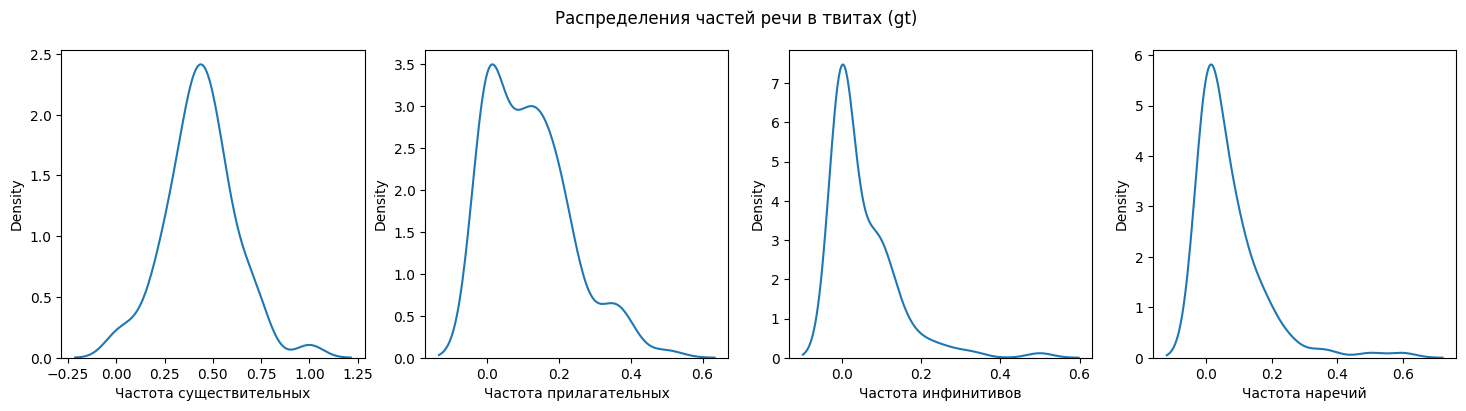

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(18,4))

sns.kdeplot(gt, x='noun_count', ax=axs[0])
axs[0].set_xlabel('Частота существительных')

sns.kdeplot(gt, x='adj_count', ax=axs[1])
axs[1].set_xlabel('Частота прилагательных')

sns.kdeplot(gt, x='infn_count', ax=axs[2])
axs[2].set_xlabel('Частота инфинитивов')

sns.kdeplot(gt, x='advb_count', ax=axs[3])
axs[3].set_xlabel('Частота наречий')

fig.suptitle('Распределения частей речи в твитах (gt)')
plt.show()

---

### Dostoevsky

In [ ]:
FastTextSocialNetworkModel.MODEL_PATH = '/content/fasttext-social-network-model.bin'
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [ ]:
def get_sentiments(text:list):

    results = model.predict(text, k=1)
    label = []
    score = []
    for x, y in list([list(x.items())[0] for x in results]):
        label.append(x)
        score.append(y)

    return (label, score)

In [ ]:
sent_label, sent_score = get_sentiments(gt['comment_text'].tolist())
gt['sentiment'] = sent_label
gt['score'] = sent_score

In [ ]:
gt[['sentiment']].value_counts()

sentiment
neutral      53
negative     46
positive      5
skip          2
speech        1
dtype: int64

In [ ]:
def get_sentiments(text:list):

    results = model.predict(text, k=1)
    label = []
    score = []
    for x, y in list([list(x.items())[0] for x in results]):
        label.append(x)
        score.append(y)

    return (label, score)

In [ ]:
sent_label, sent_score = get_sentiments(comments_text['comment_text'].tolist())
comments_text['sentiment'] = sent_label
comments_text['score'] = sent_score

---

### rubert-tiny2-cedr-emotion-detection

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2-cedr-emotion-detection')
model = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny2-cedr-emotion-detection')

In [ ]:
def get_emotions(text):

    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        logits = model(**inputs).logits
    topk_values, topk_indices = logits.topk(2)
    predicted_class_ids = topk_indices
    label_first = model.config.id2label[predicted_class_ids[0][0].item()]
    label_second = model.config.id2label[predicted_class_ids[0][1].item()]

    return ' '.join([label_first, label_second])

In [ ]:
sent_label = gt['comment_text'].apply(get_emotions)
gt['emotion'] = sent_label

In [ ]:
gt[['emotion']].value_counts()

emotion            
no_emotion anger       27
anger sadness           9
no_emotion fear         8
no_emotion sadness      7
sadness anger           7
anger surprise          6
no_emotion surprise     6
sadness fear            5
surprise anger          4
fear sadness            4
fear surprise           4
sadness no_emotion      3
anger fear              3
anger no_emotion        3
joy anger               3
fear no_emotion         3
no_emotion joy          1
joy no_emotion          1
sadness joy             1
surprise fear           1
surprise joy            1
dtype: int64

In [ ]:
sent_label = comments_text['tokens'].apply(get_emotions)
comments_text['emotion'] = sent_label

---

### Snorkel

In [ ]:
CATASTROPHIZING = 1
ABSTAIN = 0

In [ ]:
catast_regex = re.compile(
'(ничего|никогда)\sне\sполучится|это\sкатастрофа|(надо|нужно|срочно)\s(бежать|уезжать|валить)|\
конец\sсвета|ждет\s(смерть|развал|крах)|будет\s(паника|истерика)|конец\sсвета|\
в\sотчаянии|\s(это|нам)\s(страшно|конец)|никто\sне\sпоможет|(нас)\sждет|все\sкончено|\
(сойду|сойти|сошли)\sс\sума|это\sсамое\sстрашное|не\s(вынести|пережить)|(очень)\sстрашно|\
вс[её]\sпропало|не\s(помогут|поможет|смогут\sпомочь)|(умрем|погибнем)|нас\sвсех|больше\sникогда|\
(что|это)\sпроисходит|нас\sубивают|(станем|станут|станете)\sрабами|очень\sплохо|\
мы\s(пропали|пропадем|катимся)|(нет|никаких)\s(надежд|надежды)|(будет|идет)\s(паника|истерика)|\
ужасная\sсудьба'
)

@labeling_function()
def lf_regex_catast(x):
    return CATASTROPHIZING if re.search(catast_regex, x.comment_text.lower()) != None else ABSTAIN

@labeling_function()
def lf_keywords_catast(x):
    keywords_catast = ['катастрофа', 'ужас', 'ужасно', 'конец', 'проблема',
                       'паника', 'истерика', 'невозможно', 'гибель', 'трагедия',
                       'кончено', 'страх', 'умереть', 'геноцид', 'смерть', 'бояться',
                       'пережить', 'страшно', 'пропасть', 'крах', 'необратимый',
                       'губить', 'концлагерь', 'шок', 'кошмар', 'истребить',
                       'катастрофический', 'фатальный', 'непоправимый', 'ужасающий',
                       'хаос', 'хаотичный', 'пугающий', 'безнадежный', 'кошмарный']
    return CATASTROPHIZING if any(token in x.normalized_tokens for token in keywords_catast) else ABSTAIN


@labeling_function()
def lf_emotion_catast(x):
    return CATASTROPHIZING if x.sentiment in ('negative', 'neutral') and x.emotion in ['sadness fear', 'fear sadness',
                                                                                       'anger sadness', 'sadness anger',
                                                                                       'no_emotion fear', 'fear no_emotion',
                                                                                       'no_emotion anger', 'anger no_emotion'] else ABSTAIN

In [ ]:
comments_text_rdd = comments_text.to_spark().rdd

In [ ]:
lfs = [lf_keywords_catast, lf_regex_catast, lf_emotion_catast]

applier = PandasLFApplier(lfs=lfs)
L_train = SparkLFApplier(lfs=lfs).apply(comments_text_rdd)
L_dev = applier.apply(df=gt)

100%|██████████| 107/107 [00:00<00:00, 2843.20it/s]


In [ ]:
gt['is_catastrophizing'] = 1

In [ ]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=gt.is_catastrophizing.to_numpy())

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_keywords_catast,0,"[0, 1]",1.0,1.0,0.775701,60,47,0.560748
lf_regex_catast,1,"[0, 1]",1.0,1.0,0.775701,45,62,0.420561
lf_emotion_catast,2,"[0, 1]",1.0,1.0,0.775701,62,45,0.579439


In [ ]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=100, seed=0)

100%|██████████| 500/500 [00:00<00:00, 636.47epoch/s]


In [ ]:
comments_text['is_catastrophizing'] = label_model.predict(L=L_train).tolist()

In [ ]:
comments_text[comments_text['is_catastrophizing']==1]['is_catastrophizing'].count()

11988

In [ ]:
comments_text[comments_text['is_catastrophizing']==0]['is_catastrophizing'].count()

123303

In [ ]:
gt['test_labels'] = label_model.predict(L=L_dev)
draw_gt = gt[gt['test_labels']!=-1]

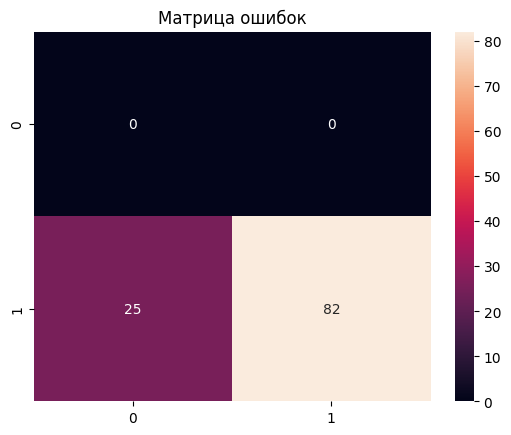

In [ ]:
sns.heatmap(confusion_matrix(draw_gt['is_catastrophizing'], draw_gt['test_labels']),
            annot=True,
            fmt='g')
plt.title('Матрица ошибок')
plt.show()

In [ ]:
print(classification_report(draw_gt['is_catastrophizing'], draw_gt['test_labels']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.77      0.87       107

    accuracy                           0.77       107
   macro avg       0.50      0.38      0.43       107
weighted avg       1.00      0.77      0.87       107



---

### Балансировка датасета

In [ ]:
# столбчатая диаграмма количества объектов по классам в наборе данных
comments_text['is_catastrophizing'].plot.hist(bins=2)

In [57]:
# minor = comments_text['is_catastrophizing'].sum()
minor = 11988

In [58]:
catast = comments_text[comments_text['is_catastrophizing'] == 1]
not_catast = comments_text[comments_text['is_catastrophizing'] == 0].iloc[:minor, :]
balanced_comments_text = ps.concat([catast, not_catast])

In [ ]:
balanced_comments_text.shape

In [ ]:
# столбчатая диаграмма количества объектов по классам в сбалансированном наборе данных
balanced_comments_text['is_catastrophizing'].plot.hist(bins=2)

In [59]:
balanced_comments_text[['comment_text', 'tokens', 'is_catastrophizing']].spark.repartition(1).to_parquet('processed_comments')

In [60]:
gt[['comment_text', 'tokens', 'is_catastrophizing']].to_csv('processed_gt.csv')